<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe30338-2021](https://jckantor.github.io/cbe30338-2021);
content is available [on Github](https://github.com/jckantor/cbe30338-2021.git).*


<!--NAVIGATION-->
< [7.3 Chemotaxis](https://jckantor.github.io/cbe30338-2021/07.03-Chemotaxis.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [7.5 Simulating Queuing Systems](https://jckantor.github.io/cbe30338-2021/07.05-Queuing-Systems-and-Poisson-Processes.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/07.04-Project-Batch-Chemical-Process.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/07.04-Project-Batch-Chemical-Process.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 7.4 Batch Chemical Process


## 7.4.1 Problem Statement

Schultheisz, Daniel, and Jude T. Sommerfeld. "Discrete-Event Simulation in Chemical Engineering." Chemical Engineering Education 22.2 (1988): 98-102.

![Batch Process](figures/BatchProcess.png)

    "... a small, single-product batch chemical plant has three identical reactors in parallel, followed by a single storage tank and a batch still. Customer orders (batches) to be filled (which begin with processing in the reactor) occur every 115 ± 30 minutes, uniformly distributed. The reaction time in a given reactor is 335 ± 60 minutes, and the distillation time in the still is 110 ± 25 minutes, both times uniformly distributed. The holding capacity of the storage tank is exactly one batch. Hence, the storage tank must be empty for a given reactor to discharge its batch; if not, the reactor cannot begin processing a new batch until the storage tank becomes empty. The simulation is to be run for 100 batches. The model should have the capability to collect waiting line statistics for the queue immediately upstream of the reactor.""
    
    
You have been hired by the client as a consulting engineer. Prepare a SimPy simulation of this process to deliver to the client. The delivery should include functions to report the key performance indicators, visualize the results of the simulation, and to conduct 'what-if' studies to determine ways to improve process performance.

## 7.4.2 Analysis

1. What is the purpose of the simulation? What question needs to be answered? In thinking about this, carefully consider what has been requested, what other questions are relevant to improving system performance.

2. What are the key performance indicators?  What data needs to be collected?

3. What simulation objects should be created for this application?

4. What classes of shared resources will be used in this model?

## 7.4.3 Simpy Shared Resources

* **[Resources](https://simpy.readthedocs.io/en/latest/api_reference/simpy.resources.html#module-simpy.resources.resource):** Models resources that are shared among mulitple processes. There is no distinction among items. You request use of a resource and then wait on availability. When the resource becomes available, you continue your process. As some point you can release the resource for use by other processes. You can specify the number of resources available, monitor the number in use, and there are provisions to assign prioriity for processes and to preempt lower priority processes. Useful if you don't need to distinguish which item is in use.

* **[Containers](https://simpy.readthedocs.io/en/latest/api_reference/simpy.resources.html#module-simpy.resources.container):** Like Resources, but for bulk homogeneous goods. Great for modeling use or production of materials.

* **[Stores](https://simpy.readthedocs.io/en/latest/api_reference/simpy.resources.html#module-simpy.resources.store):** Models the production and consumption of objects. The objects don't have to be the same, and can be represented by arbitrary Python objects.  Good for queues where objects must be treated as individual items. You can specify capacity, and used `.put()` and `.get()` to access items. You can get a list of items in the queue with `.items()`. By default, queues operate on a first-in first-out (FIFO) protocol, but other protocols can be implemented using `FilterStore` or `PriorityStore`.

We will use `Stores` to model the various order and equipment queues in this process.


## 7.4.4 Customer Orders

>... a small, single-product batch chemical plant has three identical reactors in parallel, followed by a single storage tank and a batch still. **Customer orders (batches) to be filled (which begin with processing in the reactor) occur every 115 $\pm$ 30 minutes, uniformly distributed.** The reaction time in a given reactor iis 335 $\pm$ 60 minutes, and the distillation time in the still is 110 $\pm$ 25 minutes, both times uniformly distributed. The holding capacity of the storage tank is exactly one batch. Hence, the storage tank must be empty for a given reactor to discharge its batch; if not, the reactor cannot begin processing a new batch until the storage tank becomes empty. **The simulation is to be run for 100 batches. The model should have the capability to collect waiting line statistics for the queue immediately upstream of the reactor.**

We'll begin with modeling the customer order queue. Each order has a unique identifier, the order ID. The problem statement says nothing about queue management; we will keep it simple using the default FIFO model.

In [84]:
import random
import simpy

orders = {}

env = simpy.Environment()
queue = simpy.Store(env)

env.process(order_generator())
env.run()

orders

In [35]:
queue.items

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

## 7.4.5 Batch Reactor Model

>... a small, single-product batch chemical plant has three identical reactors in parallel, followed by a single storage tank and a batch still. Customer orders (batches) to be filled (which begin with processing in the reactor) occur every 115 $\pm$ 30 minutes, uniformly distributed. **The reaction time in a given reactor iis 335 $\pm$ 60 minutes,** and the distillation time in the still is 110 $\pm$ 25 minutes, both times uniformly distributed. **The holding capacity of the storage tank is exactly one batch. Hence, the storage tank must be empty for a given reactor to discharge its batch; if not, the reactor cannot begin processing a new batch until the storage tank becomes empty.** The simulation is to be run for 100 batches. The model should have the capability to collect waiting line statistics for the queue immediately upstream of the reactor.

In [ ]:
import random
import simpy

## 7.4.6 Completed Model

<AxesSubplot:>

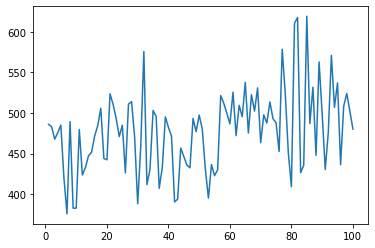

In [82]:
import random
import simpy
import pandas as pd

orders = {}

def order_generator():
    order_id = 1
    while order_id <= 100:
        yield env.timeout(random.uniform(115-30, 115+30))
        queue.put(order_id)
        orders[order_id] = {"time recv": env.now}
        order_id += 1
        
def process_order():
    while True:
        # get a reactor
        reactor = yield reactors.get()
        
        # get storage tank
        tank = yield storage_tanks.get()
  
        # get next available order
        order_id = yield queue.get()
        
        orders[order_id]["reactor"] = reactor
        orders[order_id]["tank"] = tank
        orders[order_id]["reaction started"] = env.now
        
        # batch reaction
        yield env.timeout(random.uniform(335-60, 335+60))
        
        orders[order_id]["reaction finished"] = env.now
        
        # release reactor
        reactors.put(reactor)
        
        # get still
        still = yield stills.get()
        
        # do distillation
        yield env.timeout(random.uniform(110-25, 110+25))
        
        orders[order_id]["finished"] = env.now
        
        # release equipment
        storage_tanks.put(tank)
        reactors.put(reactor)
        stills.put(still)
        
    
env = simpy.Environment()
queue = simpy.Store(env)
storage_tanks = simpy.Store(env)
storage_tanks.items = ["Tank A", "Tank B", "Tank C", "Tank D"]

reactors = simpy.Store(env)
reactors.items = ["A", "B", "C","D"]

stills = simpy.Store(env)
stills.items = ["Still A", "Still B"]

env.process(order_generator())
env.process(process_order())
env.process(process_order())
env.process(process_order())
env.process(process_order())
env.process(process_order())
env.process(process_order())
env.process(process_order())
env.process(process_order())
env.run(until = 20000)

df = pd.DataFrame(orders).T
df["elapsed"] = df["finished"] - df["time recv"]
df["elapsed"].plot()

<!--NAVIGATION-->
< [7.3 Chemotaxis](https://jckantor.github.io/cbe30338-2021/07.03-Chemotaxis.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [7.5 Simulating Queuing Systems](https://jckantor.github.io/cbe30338-2021/07.05-Queuing-Systems-and-Poisson-Processes.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/07.04-Project-Batch-Chemical-Process.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/07.04-Project-Batch-Chemical-Process.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>